In [1]:
!pip install earthengine-api
!pip install folium
!pip install python-dotenv

In [20]:
# 1. Initial Setup and Imports
import os
from sys import path
from dotenv import load_dotenv
import ee
import warnings
warnings.filterwarnings("ignore")
import logging
import folium

path.append(os.path.join(os.getcwd(), ''))
os.chdir(os.path.join(os.getcwd(), ''))

In [3]:
# 2. Earth Engine Authentication
# Replace 'your-service-account' with your actual service account email.
# Replace 'your-private-key.json' with the path to your downloaded private key JSON file.
credentials = ee.ServiceAccountCredentials('your-service-account@your-project.iam.gserviceaccount.com', 'your-private-key.json')
ee.Initialize(credentials)


In [4]:
#3. Creating Necessary Directories

!mkdir -p data/roi_geojson       # Stores the selected ROI GeoJSON file
!mkdir -p data/large_tiles       # Stores large map tiles for the selected ROI
!mkdir -p data/tile_patches      # Stores smaller image patches after splitting large tiles


In [5]:
#4. Test script to check if Google Earth Engine (GEE) API is working correctly


# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)


Mount Everest elevation (m): 8729



    "geometry": {
                "type": "GeometryCollection",
                "geometries": [
                    {
                        "type": "Point",
                        "coordinates": [YOUR_LONGITUDE, YOUR_LATITUDE]  
                        # 📍 Replace with the desired center point
                    },
                    {
                        "type": "MultiPolygon",
                        "coordinates": [
                            [
                                [
                                    [LONG1, LAT1],  # Bottom-left
                                    [LONG2, LAT1],  # Bottom-right
                                    [LONG2, LAT2],  # Top-right
                                    [LONG1, LAT2],  # Top-left
                                    [LONG1, LAT1]   # Closing the polygon
                                ]
                            ]
                        ]
                    }
                ]
            }
        }
    ]
}


In [6]:
#5. Creating and Storing ROI Polygon

import json  # Import JSON module for handling GeoJSON data
import os  # Import os module to manage directories

# ===========================
# 🌍 Define a GeoJSON for a larger Region of Interest (ROI)
# ===========================

# This GeoJSON represents a selected geographical area with:
# 1️⃣ A **Point** coordinate (a specific location)
# 2️⃣ A **MultiPolygon** (a larger area covering the ROI)

geojson_polygon = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {
                "geodesic": "false"  # Indicates whether the shape follows Earth's curvature
            },
            "geometry": {
                "type": "GeometryCollection",
                "geometries": [
                    {
                        "type": "Point",
                        "coordinates": [78.23416788531623, 17.191702083287822]
                        # 📍 A single point (Replace with your location)
                    },
                    {
                        "type": "MultiPolygon",
                        "coordinates": [
                            [
                                [   #
                                    [78.49143762785425, 17.39586892493115],  # 📌 Bottom-left corner
                                    [78.59100122648707, 17.39586892493115],  # 📌 Bottom-right corner
                                    [78.59100122648707, 17.488889247279783],  # 📌 Top-right corner
                                    [78.49143762785425, 17.488889247279783],  # 📌 Top-left corner
                                    [78.49143762785425, 17.39586892493115]   # 🔄 Closing the polygon
                                ]
                            ]
                        ]
                    }
                ]
            }
        }
    ]
}

# ===========================
# 📁 Ensure the 'roi_geojson' folder exists
# ===========================
folder_path = "/content/data/roi_geojson"
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

# ===========================
# 💾 Save the GeoJSON data to a file inside the 'roi_geojson' folder
# ===========================

file_path = os.path.join(folder_path, "selected_polygon.geojson")

# Write the GeoJSON data to the specified path
with open(file_path, "w") as f:
    json.dump(geojson_polygon, f, indent=2)

print(f"✅ GeoJSON file created: {file_path}")


✅ GeoJSON file created: /content/data/roi_geojson/selected_polygon.geojson


In [7]:
#6. Downloading and Stitching Google Maps Tiles

import math
import requests
import numpy as np
from PIL import Image
import os

def deg2num(lat_deg, lon_deg, zoom):
    """Convert latitude/longitude to tile coordinates"""
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    """Convert tile coordinates to latitude/longitude"""
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

def download_im(path, geometry, zoom):
    """Download Google Maps images for given geometry"""
    # Create directory if it doesn't exist
    if not os.path.exists(path):
        os.makedirs(path)

    # Extract coordinates
    coords = np.array(geometry['coordinates'][0])

    # Get tile coordinates for bounding box
    min_lat, max_lat = min(coords[:,1]), max(coords[:,1])
    min_lon, max_lon = min(coords[:,0]), max(coords[:,0])

    # Get tile numbers
    min_xtile, min_ytile = deg2num(min_lat, min_lon, zoom)
    max_xtile, max_ytile = deg2num(max_lat, max_lon, zoom)

    # Ensure correct order
    min_xtile, max_xtile = min(min_xtile, max_xtile), max(min_xtile, max_xtile)
    min_ytile, max_ytile = min(min_ytile, max_ytile), max(min_ytile, max_ytile)

    # Calculate number of tiles
    x_tiles = max_xtile - min_xtile + 1
    y_tiles = max_ytile - min_ytile + 1

    # Create empty image to store full map
    tile_size = 256  # Standard Google Maps tile size
    full_image = Image.new('RGB', (x_tiles * tile_size, y_tiles * tile_size))

    # Google Maps URL template
    url_template = "http://mt0.google.com/vt/lyrs=s&x={x}&y={y}&z={zoom}"

    # Download and stitch tiles
    for x in range(min_xtile, max_xtile + 1):
        for y in range(min_ytile, max_ytile + 1):
            # Construct URL for this tile
            url = url_template.format(x=x, y=y, zoom=zoom)

            try:
                # Download tile
                response = requests.get(url)
                if response.status_code == 200:
                    # Save tile temporarily
                    temp_file = f"{path}/temp_tile.png"
                    with open(temp_file, 'wb') as f:
                        f.write(response.content)

                    # Open tile and paste into correct position
                    tile = Image.open(temp_file)
                    x_pos = (x - min_xtile) * tile_size
                    y_pos = (y - min_ytile) * tile_size
                    full_image.paste(tile, (x_pos, y_pos))

                    # Clean up temporary file
                    os.remove(temp_file)
            except Exception as e:
                print(f"Error downloading tile at x={x}, y={y}: {str(e)}")

    # Save final image
    output_file = f"{path}/satellite_image_zoom_{zoom}.png"
    full_image.save(output_file)
    print(f"Saved satellite image to {output_file}")

    # Return the file path
    return output_file


📍 Understanding Zoom Levels in Satellite Imagery
Satellite images can be captured at different zoom levels, where each level represents a different scale and resolution.

Lower Zoom Levels (e.g., 17): Cover a larger geographical area with lower detail.
Higher Zoom Levels (e.g., 19, 21): Provide more detailed views but cover smaller areas.

⚡ Key Considerations:

🔹 Higher zoom levels take more time to process and require more storage space.

🔹 Choosing the right zoom level depends on the application:

Lower zoom levels are useful for large-area analysis.
Higher zoom levels are better for detailed object detection, like rooftop solar panels.

🚀 Tip: If working with high-resolution images, consider image tiling to manage processing efficiently!

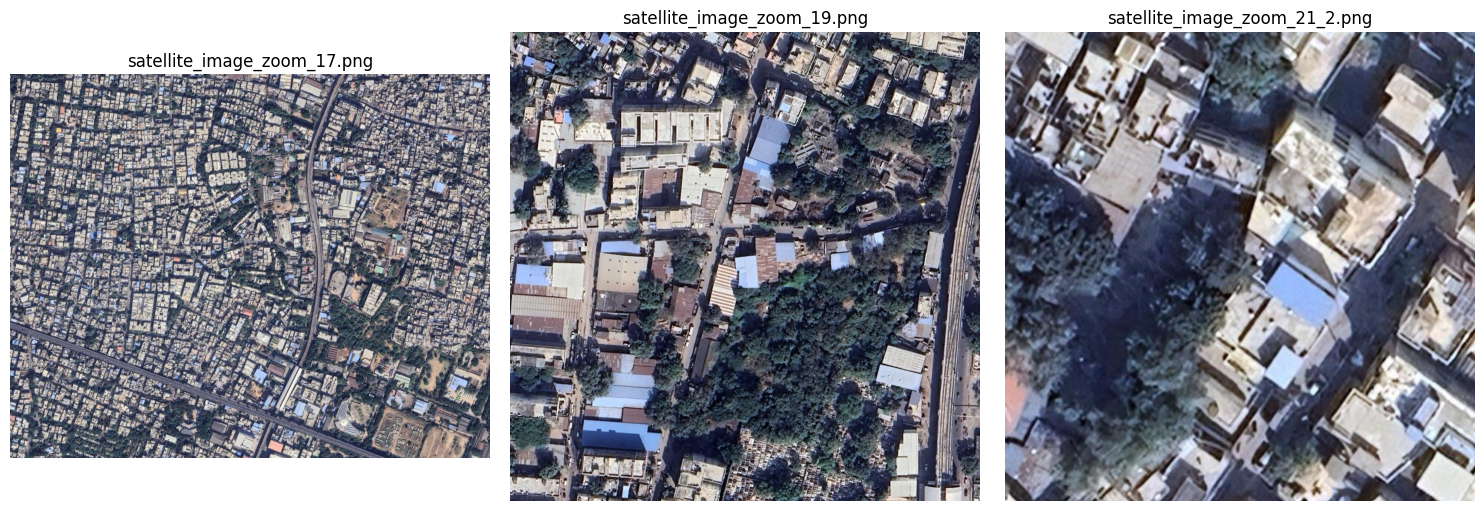

In [19]:
#7. Visualizing different zoom levels
import cv2
import matplotlib.pyplot as plt
import os

# Define the paths to your images
image_paths = [
    "/content/satellite_image_zoom_17.png",  # Replace with your actual filenames
    "/content/satellite_image_zoom_19.png",
    "/content/satellite_image_zoom_21_2.png"
]

# Load images using OpenCV
images = [cv2.imread(img_path) for img_path in image_paths]

# Convert BGR to RGB (since OpenCV loads images in BGR format)
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None for img in images]

# Check if images are loaded
if any(img is None for img in images):
    print("⚠ Some images could not be loaded. Check file paths!")

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust layout if needed

for ax, img, path in zip(axes, images, image_paths):
    if img is not None:
        ax.imshow(img)
        ax.set_title(os.path.basename(path))
    else:
        ax.set_title("Image Not Found")
    ax.axis("off")  # Hide axis

plt.tight_layout()
plt.show()


In [16]:
#8. downloading the larger tiles
import json
import os
import ee
import folium
import numpy as np
from typing import List, Dict, Any

def extract_coordinates(geometry: Dict[str, Any]) -> List[List[float]]:
    """
    Safely extract coordinates from various GeoJSON geometry structures

    Args:
    - geometry: GeoJSON geometry dictionary

    Returns:
    - List of coordinates
    """
    if geometry.get('type') == 'GeometryCollection':
        for geom in geometry.get('geometries', []):
            if geom['type'] in ['Polygon', 'MultiPolygon']:
                geometry = geom
                break

    if geometry['type'] == 'MultiPolygon':
        coords = geometry['coordinates'][0][0]
    elif geometry['type'] == 'Polygon':
        if isinstance(geometry['coordinates'][0][0], list):
            coords = geometry['coordinates'][0]
        else:
            coords = geometry['coordinates']
    else:
        raise ValueError(f"Unsupported geometry type: {geometry['type']}")

    return coords

def split_polygon(geometry: Dict[str, Any], max_tile_size: float = 0.01) -> List[Dict[str, Any]]:
    """
    Split a large polygon into smaller tiles to prevent memory overload

    Args:
    - geometry: GeoJSON geometry dictionary
    - max_tile_size: Maximum size of each tile (in degrees)

    Returns:
    - List of smaller polygon geometries
    """
    coords = extract_coordinates(geometry)

    lons = [coord[0] for coord in coords]
    lats = [coord[1] for coord in coords]

    min_lon, max_lon = min(lons), max(lons)
    min_lat, max_lat = min(lats), max(lats)

    tiles = []
    for lon in range(int((max_lon - min_lon) / max_tile_size) + 1):
        for lat in range(int((max_lat - min_lat) / max_tile_size) + 1):
            tile_min_lon = min_lon + lon * max_tile_size
            tile_max_lon = min_lon + (lon + 1) * max_tile_size
            tile_min_lat = min_lat + lat * max_tile_size
            tile_max_lat = min_lat + (lat + 1) * max_tile_size

            tile_coords = [
                [tile_min_lon, tile_min_lat],
                [tile_max_lon, tile_min_lat],
                [tile_max_lon, tile_max_lat],
                [tile_min_lon, tile_max_lat],
                [tile_min_lon, tile_min_lat]
            ]

            tile_geometry = {
                'type': 'Polygon',
                'coordinates': [tile_coords]
            }

            tiles.append(tile_geometry)

    return tiles

def download_large_roi(input_geojson: str, output_path: str, zoom: int = 21):# set the zoom level here
    """
    Download satellite/map images for a large ROI by splitting it into tiles.

    Args:
    - input_geojson: Path to input GeoJSON file.
    - output_path: Directory to save downloaded images.
    - zoom: Zoom level for image download.
    """
    os.makedirs(output_path, exist_ok=True)

    with open(input_geojson, 'r') as f:
        data = json.load(f)

    try:
        if 'features' in data:
            geometry = data['features'][0]['geometry']
        elif 'geometry' in data:
            geometry = data['geometry']
        else:
            raise ValueError("Cannot find geometry in GeoJSON")
    except Exception as e:
        print(f"Error extracting geometry: {e}")
        raise

    tiles = split_polygon(geometry)
    print("Region to download: ", geometry)
    print(f"Total number of tiles to be processed: {len(tiles)}")

    for i, tile in enumerate(tiles):
        try:
            tile_output_path = os.path.join(output_path, f'tile_{i}')
            os.makedirs(tile_output_path, exist_ok=True)

            # Placeholder for the download function
            download_im(tile_output_path, tile, zoom)

            print(f"Tile {i + 1}/{len(tiles)} processed successfully.")
        except Exception as e:
            print(f"Error processing tile {i + 1}/{len(tiles)}: {e}")

def visualize_tiles(input_geojson: str, output_html: str = 'tiles_map.html'):
    """
    Create a Folium map to visualize the tiles

    Args:
    - input_geojson: Path to input GeoJSON file
    - output_html: Path to save the HTML map
    """
    with open(input_geojson, 'r') as f:
        data = json.load(f)

    try:
        if 'features' in data:
            geometry = data['features'][0]['geometry']
        elif 'geometry' in data:
            geometry = data['geometry']
        else:
            raise ValueError("Cannot find geometry in GeoJSON")
    except Exception as e:
        print(f"Error extracting geometry: {e}")
        raise

    coords = extract_coordinates(geometry)

    center_lon = sum(coord[0] for coord in coords) / len(coords)
    center_lat = sum(coord[1] for coord in coords) / len(coords)

    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    folium.GeoJson(
        data={'type': 'Feature', 'geometry': geometry},
        name='Original ROI',
        style_function=lambda x: {'color': 'red', 'weight': 2, 'fillOpacity': 0.1}
    ).add_to(m)

    tiles = split_polygon(geometry)

    for i, tile in enumerate(tiles):
        folium.GeoJson(
            data=tile,
            name=f'Tile {i}',
            style_function=lambda x: {'color': 'blue', 'weight': 1, 'fillOpacity': 0.1}
        ).add_to(m)

    m.save(output_html)
    print(f"Tile visualization saved to {output_html}")

# Example usage
if __name__ == "__main__":
    input_geojson = '/content/data/roi_geojson/selected_polygon.geojson'
    output_path = '/content/data/large_tiles'
    download_large_roi(input_geojson, output_path)
    visualize_tiles(input_geojson)


Region to download:  {'type': 'GeometryCollection', 'geometries': [{'type': 'Point', 'coordinates': [78.23416788531623, 17.191702083287822]}, {'type': 'MultiPolygon', 'coordinates': [[[[78.49143762785425, 17.39586892493115], [78.59100122648707, 17.39586892493115], [78.59100122648707, 17.488889247279783], [78.49143762785425, 17.488889247279783], [78.49143762785425, 17.39586892493115]]]]}]}
Total number of tiles to be processed: 100
Saved satellite image to /content/data/large_tiles/tile_0/satellite_image_zoom_21.png
Tile 1/100 processed successfully.
Saved satellite image to /content/data/large_tiles/tile_1/satellite_image_zoom_21.png
Tile 2/100 processed successfully.


KeyboardInterrupt: 

In [18]:
#9. splitting the large_tiles to smaller patches of desired size

import cv2
import os

def split_satellite_images(input_dir: str = '/content/data/large_tiles',
                           output_base: str = '/content/data/tile_patches',
                           patch_size: int = 1024):# set the size for smaller patches here
    """
    Processes all tiles in the input directory and splits their images into patches.
    The script automatically finds the image file inside each tile folder.
    """
    # Create base output directory
    os.makedirs(output_base, exist_ok=True)

    # Get all tile folders
    tile_folders = [f for f in os.listdir(input_dir) if f.startswith('tile_')]

    print(f"Found {len(tile_folders)} tiles to process")

    for tile_folder in tile_folders:
        # Create output directory for current tile
        tile_output_path = os.path.join(output_base, f'{tile_folder}_patches')
        os.makedirs(tile_output_path, exist_ok=True)

        # Get the image file dynamically (assuming only one image per folder)
        tile_path = os.path.join(input_dir, tile_folder)
        image_files = [f for f in os.listdir(tile_path) if f.endswith(('.png', '.jpg', '.tif'))]

        if not image_files:
            print(f"⚠ No image found in {tile_folder}, skipping...")
            continue

        image_path = os.path.join(tile_path, image_files[0])  # Select the first image found

        print(f"\nProcessing {tile_folder} -> {image_files[0]}")

        # Read the large satellite image
        img = cv2.imread(image_path)
        if img is None:
            print(f"⚠ Error reading image {image_files[0]}, skipping...")
            continue

        height, width = img.shape[:2]

        # Calculate number of patches
        num_patches_h = height // patch_size
        num_patches_w = width // patch_size

        print(f"Creating {num_patches_h * num_patches_w} patches of {patch_size}x{patch_size} pixels")

        # Extract and save patches
        patch_idx = 0
        for h in range(num_patches_h):
            for w in range(num_patches_w):
                start_h = h * patch_size
                start_w = w * patch_size
                patch = img[start_h:start_h + patch_size, start_w:start_w + patch_size]

                patch_filename = os.path.join(tile_output_path, f'patch_{patch_idx}.png')
                cv2.imwrite(patch_filename, patch)

                patch_idx += 1
                print(f"Saved patch {patch_idx}/{num_patches_h * num_patches_w}")

# Run the splitting process
split_satellite_images()


Found 4 tiles to process
⚠ No image found in tile_2, skipping...

Processing tile_0 -> satellite_image_zoom_21.png
Creating 225 patches of 1024x1024 pixels
Saved patch 1/225
Saved patch 2/225
Saved patch 3/225
Saved patch 4/225
Saved patch 5/225
Saved patch 6/225
Saved patch 7/225
Saved patch 8/225
Saved patch 9/225
Saved patch 10/225
Saved patch 11/225
Saved patch 12/225
Saved patch 13/225
Saved patch 14/225
Saved patch 15/225
Saved patch 16/225
Saved patch 17/225
Saved patch 18/225
Saved patch 19/225
Saved patch 20/225
Saved patch 21/225
Saved patch 22/225
Saved patch 23/225
Saved patch 24/225
Saved patch 25/225
Saved patch 26/225
Saved patch 27/225
Saved patch 28/225
Saved patch 29/225
Saved patch 30/225
Saved patch 31/225
Saved patch 32/225
Saved patch 33/225
Saved patch 34/225
Saved patch 35/225
Saved patch 36/225
Saved patch 37/225
Saved patch 38/225
Saved patch 39/225
Saved patch 40/225
Saved patch 41/225
Saved patch 42/225
Saved patch 43/225
Saved patch 44/225
Saved patch 45/22